# how do time and weather factors contribute to the amount of bikes checked in and out?

This is a regression problem!


You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
Data Fields

datetime - hourly date + timestamp  

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter  <br/>

holiday - whether the day is considered a holiday <br/>

workingday - whether the day is neither a weekend nor holiday <br/>

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy <br/>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br/>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br/>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br/>

temp - temperature in Celsius <br/>

atemp - "feels like" temperature in Celsius <br/>

humidity - relative humidity <br/>

windspeed - wind speed <br/>

casual - number of non-registered user rentals initiated <br/>
registered - number of registered user rentals initiated <br/>

count - number of total rentals <br/>

### train.csv
- 1-19th day of month is training

### test.csv
- 20th -30th/31st day of month is testing

### Questions for data exploration:

- Which factors contribute most to the number of bicycles being checkout out over the course of a given day?
- How much of an impact does weather have on demand?
- How does the behavior of casual users differ from subscribers?

The value in the count column is the one you need to predict.

Notes:
- different behaviour between groups using the bikes (tourists just really short) vs subscribers - interesting for the business questions (maybe different peaks)

- X = potentially everything except causaul, registered, count
- y = count

In [435]:
import pandas as pd

In [436]:
df = pd.read_csv('train.csv')
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### 1.1 Overview (column names, NaN count, dtype) and summary stats (max, min, mean per col)

In [437]:
print(
      '\n\n info\n', df.info(),
     '\n\nsummary stats\n', df.describe(),
     '\n\nmedian\n', df.median()
)

# no missing values
# datetime is object dtype
# holiday and workingday: binary
# weather (category) and season from 1 to 4
# atemp has greater range than temp 
# more registered than causual users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


 info
 None 

summary stats
              season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427    

In [438]:
print(df['weather'].value_counts(), '\n', # weather codes from 1 - 4 

# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

# expectation: on days with weather cat 1 and workingday== 1 most bikes were rented
      
  df['holiday'].value_counts(), '\n', # 1 == day was a public holiday,
 df['workingday'].value_counts() # 1 == day was a working day (people commuted)      
     )

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64 
 0    10575
1      311
Name: holiday, dtype: int64 
 1    7412
0    3474
Name: workingday, dtype: int64


### 1.2 Convert datetime column to datetime format

In [439]:
# object == string
#df['datetime'].str[10:15] # naive way of extracting featurs from a datetime "string"


# one of the best function:
# puts it into a standardized format
#pd.to_datetime('jan-1 2020')

df['datetime'] = pd.to_datetime(df['datetime']) # convert column
df['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

#### through the functionality of the modul you can access days, months, hours to create new columns


In [440]:
df['datetime'].dt.day
#df['datatime'].dt.month
#df['datatime'].dt.dayofweek
#df['datatime'].dt.year

0         1
1         1
2         1
3         1
4         1
         ..
10881    19
10882    19
10883    19
10884    19
10885    19
Name: datetime, Length: 10886, dtype: int64

In [441]:
# create month, day of week and hour columns
df['month'] = df['datetime'].dt.month
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour
df['dayofyear'] = df['datetime'].dt.dayofyear

df.head(24) # 2011-01-01 first day 
df.tail() # 2012-12-19 23:00:00 last day  -> 2 years of data 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,dayofweek,hour,dayofyear
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,12,2,19,354
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,12,2,20,354
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,12,2,21,354
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,12,2,22,354
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,12,2,23,354


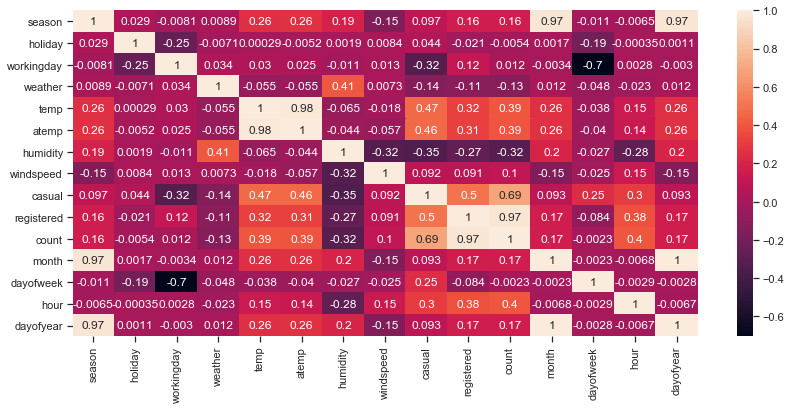

In [442]:
import seaborn as sns
plt.figure(figsize=(14, 6))

Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)


#### Which factors contribute most to the number of bicycles being checkout out over the course of a given day?
* 1. hour 0.4
* 2. temp / atemp 0.39 (pos corr: warmer temp, more bikes rented)
* 3. humidity -0.32 (neg corr: less humid, more bikes rented)
* 4. month 0.17
* 5. season 0.16
* 6. windspeed 0.15
* 7. weather cat -0.13
* 8. workingday 0.012
* 9. holiday -0.0054



### Datetime slicing
In pandas, if you make the timestamp/ datetime the index, it allows for very easy slicing


In [443]:
df.set_index('datetime', inplace=True)
# df['jan 4 2011' : 'feb 5 2011'] # makes slicing much easier
# df['january 2011']

### User behaviour throughout one day


In [444]:
# slice dataframe to one day

# check a working day in spring
df_spring_workday = df['2011-04-05 00:00:00' : '2011-04-05 23:00:00']
# rush our between 7pm and 9pm and 4pm to 7pm
df_spring_workday

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,dayofweek,hour,dayofyear
datetime,,,,,,,,,,,,,,,
2011-04-05 00:00:00,2,0,1,1,25.42,31.060,50,7.0015,10,12,22,4,1,0,95
2011-04-05 01:00:00,2,0,1,3,25.42,31.060,57,27.9993,10,5,15,4,1,1,95
2011-04-05 02:00:00,2,0,1,2,22.14,25.760,73,22.0028,0,5,5,4,1,2,95
2011-04-05 03:00:00,2,0,1,2,22.14,25.760,73,22.0028,1,3,4,4,1,3,95
2011-04-05 04:00:00,2,0,1,3,20.50,24.240,88,32.9975,0,2,2,4,1,4,95
2011-04-05 05:00:00,2,0,1,3,18.86,22.725,94,19.9995,0,5,5,4,1,5,95
2011-04-05 06:00:00,2,0,1,2,19.68,23.485,88,22.0028,2,36,38,4,1,6,95
2011-04-05 07:00:00,2,0,1,2,19.68,23.485,88,22.0028,10,124,134,4,1,7,95
2011-04-05 08:00:00,2,0,1,3,15.58,19.695,87,39.0007,9,148,157,4,1,8,95


In [445]:
# check for weekend
df_spring_weekend = df['2011-06-05 00:00:00' : '2011-06-05 23:00:00']
# lots of bikes rented from 9am to 9pm
df_spring_weekend 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,dayofweek,hour,dayofyear
datetime,,,,,,,,,,,,,,,
2011-06-05 00:00:00,2,0,0,1,26.24,31.060,57,6.0032,23,90,113,6,6,0,156
2011-06-05 01:00:00,2,0,0,2,26.24,31.060,61,11.0014,26,70,96,6,6,1,156
2011-06-05 02:00:00,2,0,0,2,26.24,31.060,61,11.0014,16,48,64,6,6,2,156
2011-06-05 03:00:00,2,0,0,2,25.42,30.305,65,11.0014,22,25,47,6,6,3,156
2011-06-05 04:00:00,2,0,0,2,25.42,30.305,65,11.0014,4,8,12,6,6,4,156
2011-06-05 05:00:00,2,0,0,2,25.42,30.305,61,8.9981,1,5,6,6,6,5,156
2011-06-05 06:00:00,2,0,0,2,25.42,30.305,61,7.0015,10,11,21,6,6,6,156
2011-06-05 07:00:00,2,0,0,2,24.60,29.545,73,16.9979,8,19,27,6,6,7,156
2011-06-05 08:00:00,2,0,0,2,24.60,29.545,73,16.9979,24,74,98,6,6,8,156


/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


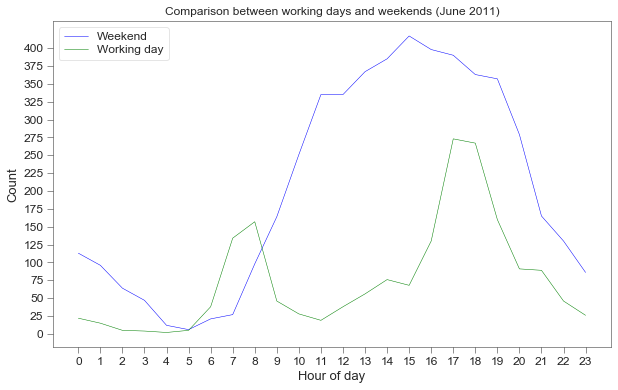

In [446]:
# plot bike rental counts over time for a day
df_spring_workday= df_spring_workday.reset_index()
df_spring_weekend= df_spring_weekend.reset_index()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Comparison between working days and weekends (June 2011)")
axis_font = {'fontname':'Arial', 'size':'13'}

ax = plt.subplot() # Defines ax variable by creating an empty plot
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)


plt.plot('hour', 'count', data=df_spring_weekend, marker='', color='blue', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects
plt.plot('hour', 'count', data=df_spring_workday, marker='', color='green', linewidth=0.5, linestyle='solid', label='Working day') #


axes= plt.axes()
plt.tick_params(width = 0.5)
plt.setp(axes.spines.values(), linewidth=0.5)

axes.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
#axes.set_xtickslabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])

axes.set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])
#axes.set_ytickslabel(['0', '25', '50', '75', '100', '125', '150', '175', '200', '225', '250', '275', '300', '325', '350', '375', '400'])


plt.xlabel("Hour of day", axis_font)
plt.ylabel("Count", axis_font)

L=plt.legend(loc='upper left', fontsize='medium', labelspacing=0.2, framealpha=0.5)
L.get_texts()[0].set_text('Weekend')
L.get_texts()[1].set_text('Working day')

### How does the behavior of casual users differ from subscribers?


In [447]:
# create subdateframe for two weeks
df_week_may = df['2011-06-06 00:00:00' : '2011-06-19 23:00:00']
df_week_may= df_week_may.reset_index()
df_week_may.head(50)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,dayofweek,hour,dayofyear
0,2011-06-06 00:00:00,2,0,1,1,25.42,29.545,78,8.9981,11,18,29,6,0,0,157
1,2011-06-06 01:00:00,2,0,1,1,24.60,28.030,83,8.9981,9,5,14,6,0,1,157
2,2011-06-06 02:00:00,2,0,1,1,23.78,27.275,88,7.0015,4,4,8,6,0,2,157
3,2011-06-06 03:00:00,2,0,1,1,23.78,27.275,88,0.0000,2,3,5,6,0,3,157
4,2011-06-06 04:00:00,2,0,1,1,22.96,26.515,94,7.0015,4,4,8,6,0,4,157
5,2011-06-06 05:00:00,2,0,1,1,22.96,26.515,88,6.0032,7,24,31,6,0,5,157
6,2011-06-06 06:00:00,2,0,1,1,23.78,27.275,88,0.0000,11,101,112,6,0,6,157
7,2011-06-06 07:00:00,2,0,1,1,25.42,29.545,78,7.0015,18,281,299,6,0,7,157
8,2011-06-06 08:00:00,2,0,1,1,26.24,30.305,73,6.0032,28,410,438,6,0,8,157
9,2011-06-06 09:00:00,2,0,1,1,28.70,32.575,58,11.0014,26,162,188,6,0,9,157


/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


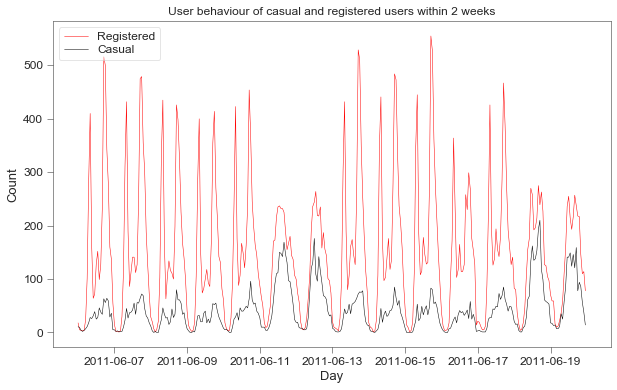

In [448]:


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("User behaviour of casual and registered users within 2 weeks")
axis_font = {'fontname':'Arial', 'size':'13'}





ax = plt.subplot() # Defines ax variable by creating an empty plot
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)


#plt.plot('datetime', 'count', data=df_week_may, marker='', color='blue', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects
plt.plot('datetime', 'registered', data=df_week_may, marker='', color='red', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects
plt.plot('datetime', 'casual', data=df_week_may, marker='', color='black', linewidth=0.5, linestyle='solid', label='Working day') #


axes= plt.axes()
plt.tick_params(width = 0.5)
plt.setp(axes.spines.values(), linewidth=0.5)



plt.xlabel("Day", axis_font)
plt.ylabel("Count", axis_font)

L=plt.legend(loc='upper left', fontsize='medium', labelspacing=0.2, framealpha=0.5)
L.get_texts()[1].set_text('Casual')
L.get_texts()[0].set_text('Registered')


- significant less registered users at the weekends
- casual users twice as much at the weekends (tourists)

In [491]:
### User behaviour throughout the year
df_year = df['2011-01-01 00:00:00' : '2011-12-31 23:00:00']
df_year.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,dayofweek,hour,dayofyear
datetime,,,,,,,,,,,,,,,
2012-01-01 00:00:00,1,0,0,1,14.76,18.940,66,0.0000,5,43,48,1,6,0,1
2012-01-01 01:00:00,1,0,0,1,14.76,17.425,66,8.9981,15,78,93,1,6,1,1
2012-01-01 02:00:00,1,0,0,1,13.12,17.425,76,0.0000,16,59,75,1,6,2,1
2012-01-01 03:00:00,1,0,0,1,12.30,16.665,81,0.0000,11,41,52,1,6,3,1
2012-01-01 04:00:00,1,0,0,1,11.48,15.150,81,6.0032,0,8,8,1,6,4,1


In [492]:
# get day of year
count_day_of_year = df_year[['count', 'casual', 'registered']].groupby(df_year["dayofyear"]).sum()
count_day_of_year = pd.DataFrame(count_day_of_year)
count_day_of_year = count_day_of_year.reset_index()
count_day_of_year

,dayofyear,count,casual,registered
0,1,2294,686,1608
1,2,1951,244,1707
2,3,2236,89,2147
3,4,2368,95,2273
4,5,3272,140,3132
...,...,...,...,...
223,350,5047,767,4280
224,351,3786,538,3248
225,352,4585,212,4373
226,353,5557,433,5124


/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


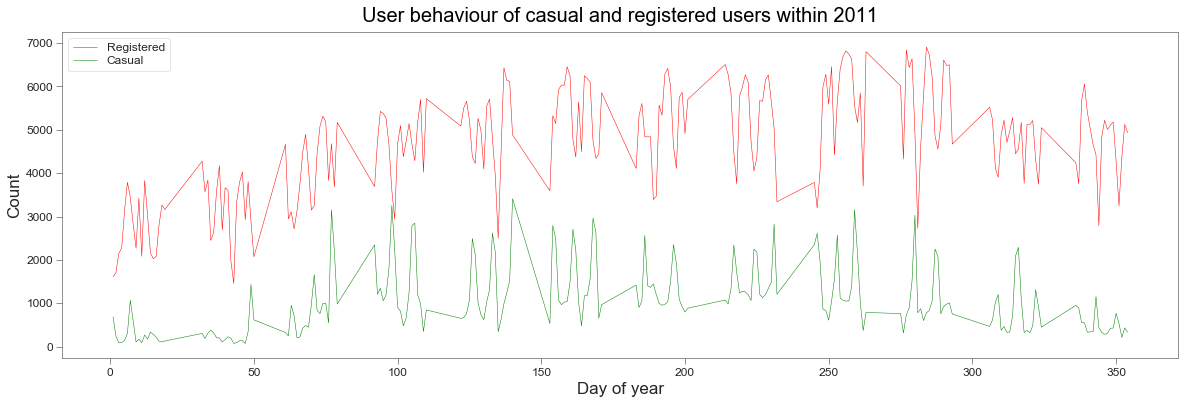

In [493]:


plt.figure(figsize=(20, 6))

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("User behaviour of casual and registered users within 2011", title_font)
axis_font = {'fontname':'Arial', 'size':'17'}





ax = plt.subplot() # Defines ax variable by creating an empty plot
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
plt.plot('dayofyear', 'registered', data=count_day_of_year, marker='', color='red', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects
plt.plot('dayofyear', 'casual', data=count_day_of_year, marker='', color='green', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects


axes= plt.axes()
plt.tick_params(width = 0.5)
plt.setp(axes.spines.values(), linewidth=0.5)

plt.xlabel("Day of year", axis_font)
plt.ylabel("Count", axis_font)

L=plt.legend(loc='upper left', fontsize='medium', labelspacing=0.2, framealpha=0.5)
L.get_texts()[1].set_text('Casual')
L.get_texts()[0].set_text('Registered')

- first 4 months (until april) less users
- strong fluctuations visible, probably due to weather conditions

/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


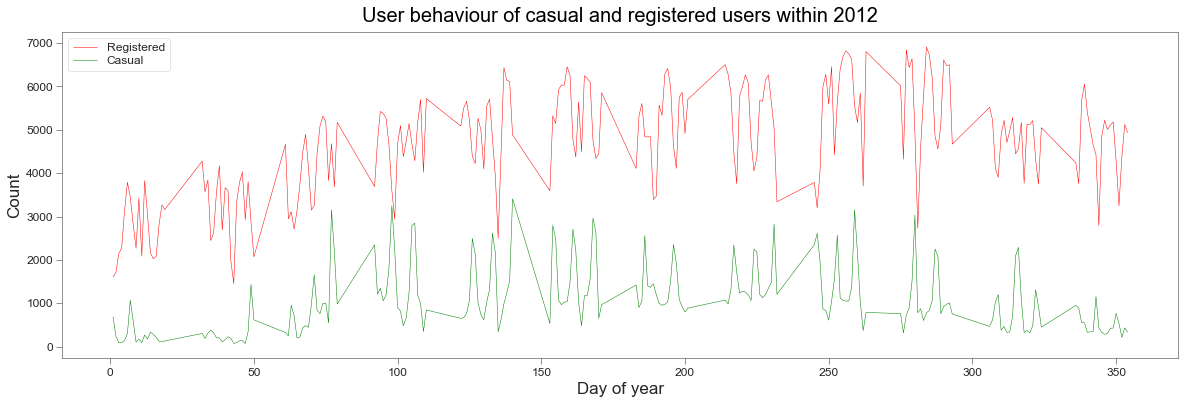

In [495]:
# for 2012
### User behaviour throughout the year
df_year_2012 = df['2012-01-01 00:00:00' : '2012-12-31 23:00:00']
df_year_2012.head()

# get day of year
count_day_of_year = df_year_2012[['count', 'casual', 'registered']].groupby(df_year_2012["dayofyear"]).sum()
count_day_of_year = pd.DataFrame(count_day_of_year)
count_day_of_year = count_day_of_year.reset_index()
count_day_of_year

plt.figure(figsize=(20, 6))

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("User behaviour of casual and registered users within 2012", title_font)
axis_font = {'fontname':'Arial', 'size':'17'}





ax = plt.subplot() # Defines ax variable by creating an empty plot
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
plt.plot('dayofyear', 'registered', data=count_day_of_year, marker='', color='red', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects
plt.plot('dayofyear', 'casual', data=count_day_of_year, marker='', color='green', linewidth=0.5, linestyle='solid', label='Weekend') # no other objects


axes= plt.axes()
plt.tick_params(width = 0.5)
plt.setp(axes.spines.values(), linewidth=0.5)

plt.xlabel("Day of year", axis_font)
plt.ylabel("Count", axis_font)

L=plt.legend(loc='upper left', fontsize='medium', labelspacing=0.2, framealpha=0.5)
L.get_texts()[1].set_text('Casual')
L.get_texts()[0].set_text('Registered')

#### How much of an impact does weather have on demand?

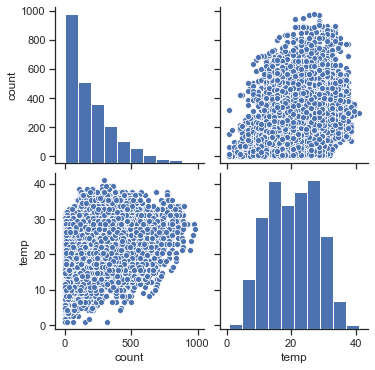

In [389]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

df_temp = df[['count', 'temp']]

g = sns.pairplot(df_temp)

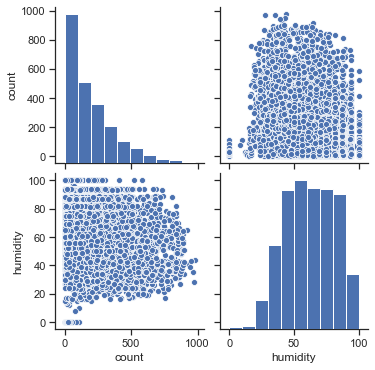

In [390]:
df_hum = df[['count', 'humidity']]

g = sns.pairplot(df_hum)

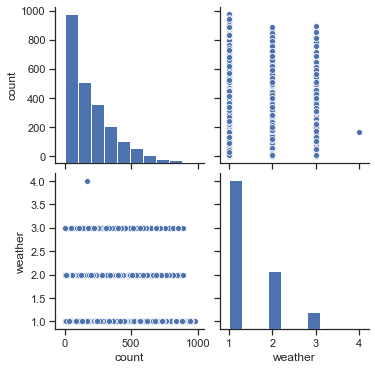

In [392]:
df_weat = df[['count', 'weather']]

g = sns.pairplot(df_weat)

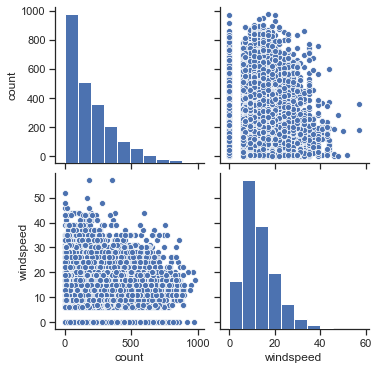

In [414]:
df_wind = df[['count', 'windspeed']]

g = sns.pairplot(df_wind)

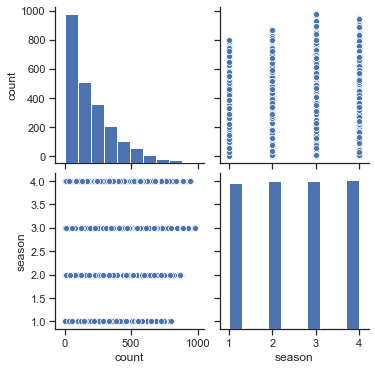

In [416]:
df_seas = df[['count', 'season']]

g = sns.pairplot(df_seas)

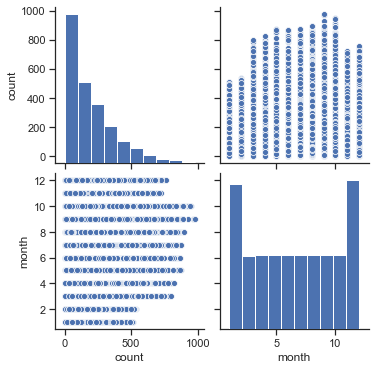

In [415]:
df_month = df[['count', 'month']]

g = sns.pairplot(df_month)